
## imports

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


## Initialize here input variables

In [2]:
conv_layers = 3
kernel_sizes = [(7, 7), (5, 5), (3, 3)]
filters = [8, 16, 32]
epochs = 3
batch_size = 32
third_maxpool = True

## load the Dataset

In [3]:
def parse_dataset(filepath):
    """ function used to parse the data of a dataset """

    # open the dataset
    with open(filepath, "rb") as dataset:
        # read the magic number and the number of images
        magic_number, number_of_images = struct.unpack(">II", dataset.read(8))
        # read the number of rows and number of columns per image
        rows, columns = struct.unpack(">II", dataset.read(8))
        # now read the rest of the file using numpy.fromfile()
        images = np.fromfile(dataset, dtype=np.dtype(np.uint8).newbyteorder(">"))
        # reshape so that the final shape is (number_of_images, rows, columns)
        images = images.reshape((number_of_images, rows, columns))

    # return the images
    return images


def parse_labelset(filepath):
    """ function used to parse the data of a labelset """

    # open the file
    with open(filepath, "rb") as labelset:
        # read the magic number and the number of labels
        magic_number, number_of_labels = struct.unpack(">II", labelset.read(8))
        # now read the rest of the file using numpy.fromfile()
        labels = np.fromfile(labelset, dtype=np.dtype(np.uint8).newbyteorder(">"))

    # return the labels
    return labels

In [4]:
# EDIT THE PATHS OF THE DATASETS HERE
train_images_path = os.path.join(".", "drive", "My Drive", "Colab Notebooks", "Project", "Project2", "Dataset", "train-images-idx3-ubyte")
train_labels_path = os.path.join(".", "drive", "My Drive", "Colab Notebooks", "Project", "Project2", "Dataset", "train-labels-idx1-ubyte")

test_images_path = os.path.join(".", "drive", "My Drive", "Colab Notebooks", "Project", "Project2", "Dataset", "t10k-images-idx3-ubyte")
test_labels_path = os.path.join(".", "drive", "My Drive", "Colab Notebooks", "Project", "Project2", "Dataset", "t10k-labels-idx1-ubyte")


# LOAD THE DATASETS HERE
X_train = parse_dataset(train_images_path)
y_train = parse_labelset(train_labels_path)

X_test = parse_dataset(test_images_path)
y_test = parse_labelset(test_labels_path)

# GET USEFUL VARIABLES
rows = X_train.shape[1]
columns = X_train.shape[2]

# GET VALIDATION DATASET FROM TRAINING SET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=13, shuffle=True)

# RESHAPE SO THAT THE FINAL SHAPE IS (number_of_images, rows, columns, 1)
X_train = X_train.reshape(-1, rows, columns, 1)
X_val = X_val.reshape(-1, rows, columns, 1)
X_test = X_test.reshape(-1, rows, columns, 1)

# SCALE INPUT
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.


# PRINTS TO MAKE SURE
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print()
print("X_val.shape = {}".format(X_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print()
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (51000, 28, 28, 1)
y_train.shape = (51000,)

X_val.shape = (9000, 28, 28, 1)
y_val.shape = (9000,)

X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000,)


## print utilities

In [5]:
def print_image(image, rows, columns):
    """ function used to print an image to the console """

    # for each row of the image
    for i in range(rows):
        # for each column
        for j in range(columns):
            # print the value at the coordinate (i, j) if it is not 0
            if image[i, j] != 0:
                print("{:.3f}".format(image[i, j, 0]), end="")
            else:
                print("   ", end="")
        # print a newline since the row has finished
        print()
    print()


def plot_image(image):
    """ fuction used to plot an image using matplotlib """

    # plot and show the image
    plt.imshow(image, cmap="gray")
    plt.show()

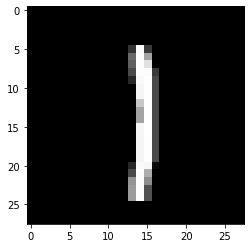

In [6]:
plot_image(X_train[69, :, :, 0])

# Autoencoder

## functions to create autoencoder

In [7]:
def create_encoder(rows, columns, conv_layers, kernel_sizes, filters, use_third_max_pooling=True,
                   use_leaky_relu=False, leaky_relu_alpha=0.15):
    """
    Function used to create the encoder part of the autoencoder. The architecture follows the
    following rules:

    1) Every Convolutional Layer is followed by a Batch Batch Normalization.

    2) The First 3 Convolutional Layers also have a Max Pooling at the end. The first 2 Max Pooling
       layers have a pool size of (2, 2), while the third (if used) has a pool size of (7, 7). If
       less than 3 Convolutional Layers are available, then fewer Max Pooling layers are used.

    3) The activation function used in the Convolutional Layers is ReLU, but it can be changed to
       using Leaky ReLU just by setting the parameter "use_leaky_relu" to True and picking an alpha.

    4) Padding in Convolutions is always "same", that is, the output image from the convolution has
       the same shape as the input. Only the Max Pooling layers reduce the dimension of the images.
    """

    # define the input
    input = Input(shape=(rows, columns, 1))
    x = input

    # place the Convolutional-BatchNormalization-[MaxPooling] sets of layers
    for layer in range(conv_layers):

        # determine whether to use ReLU or Leaky ReLU
        if not use_leaky_relu:
            x = Conv2D(filters=filters[layer], kernel_size=kernel_sizes[layer], activation="relu",
                       padding="same")(x)
        else:
            x = Conv2D(filters=filters[layer], kernel_size=kernel_sizes[layer], activation="linear",
                       padding="same")(x)
            x = LeakyReLU(alpha=leaky_relu_alpha)(x)

        # perform batch normalization
        x = BatchNormalization()(x)

        # if we are placing a the 3rd layer and MaxPooling should be placed, do it
        if layer == 2 and use_third_max_pooling:
            x = MaxPooling2D(pool_size=(7, 7))(x)
        # if we are in the placing of the first 2 layers, place also a MaxPooling
        if layer < 2:
            x = MaxPooling2D(pool_size=(2, 2))(x)

    # create the encoder part and return it
    encoder = Model(input, x, name="encoder")
    return encoder


def create_decoder(rows, columns, conv_layers, kernel_sizes, filters, use_third_max_pooling=True,
                   use_leaky_relu=False, leaky_relu_alpha=0.15):
    """
    Function used to create the decoder part of the Autoencoder. The architecture is basically the
    "mirrored" architecture of the encoder.
    """

    # define the input
    factor = min(conv_layers, 2) * 2
    if conv_layers >= 3 and use_third_max_pooling:
        factor *= 7
    input_rows = rows // factor
    input_columns = columns // factor
    input = Input(shape=(input_rows, input_columns, filters[-1]))
    x = input

    # place the Convolutional-BatchNormalization-[MaxPooling] sets of layers in a mirrored way
    last_layer = len(filters) - 1
    for layer in range(last_layer, -1, -1):

        # determine whether to use Leaky ReLU or normal ReLU
        if not use_leaky_relu:
            x = Conv2D(filters=filters[layer], kernel_size=kernel_sizes[layer], activation="relu",
                       padding="same")(x)
        else:
            x = Conv2D(filters=filters[-1], kernel_size=kernel_sizes[-1], activation="linear",
                       padding="same")(input)
            x = LeakyReLU(alpha=leaky_relu_alpha)(x)

        # add batch normalization
        x = BatchNormalization()(x)

        # if we are in the third layer and a 3rd Max Pooling was placed, place an UpSampling
        if layer == 2 and use_third_max_pooling:
            x = UpSampling2D(size=(7, 7))(x)
        # if we are in the first 2 layers, place an UpSampling
        if layer < 2:
            x = UpSampling2D(size=(2, 2))(x)

    # do the final convolution to convert the image to the normal shape
    x = Conv2D(filters=1, kernel_size=kernel_sizes[-1], activation="sigmoid", padding="same")(x)

    # create the decoder part and return it
    decoder = Model(input, x, name="decoder")
    return decoder


def create_autoencoder(rows, columns, encoder, decoder):
    """
    Function that given the encoder part and the decoder part of an autoencoder, creates a "Model"
    (Keras object) that represents an autoencoder.
    """

    # define the input
    input = Input(shape=(rows, columns, 1))

    # pass the input through the encoder
    x = encoder(input)

    # pass then the result through the decoder
    x = decoder(x)

    # create the model and return it
    autoencoder = Model(input, x, name="autoencoder")
    return autoencoder

## create the autoencoder

In [8]:
# get the encoder and the decoder
encoder = create_encoder(rows, columns, conv_layers, kernel_sizes, filters)
decoder = create_decoder(rows, columns, conv_layers, kernel_sizes, filters)

# print summaries
print(encoder.summary())
print(decoder.summary())

# get the autoencoder
autoencoder = create_autoencoder(rows, columns, encoder, decoder)
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         400       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        3216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0   

## create a custom callback for when the validation loss plateaus

In [9]:
# add a callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=1.0/2, patience=4, min_delta=0.005,
                              cooldown=0, min_lr=1e-8, verbose=1)

## train the autoencoder

In [10]:
# compile and train the autoencoder
autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss="mse", metrics=["mse"])
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs,
                          shuffle=True, validation_data=(X_val, X_val), callbacks=[reduce_lr])

Epoch 1/3
1594/1594 [==============================] - 8s 5ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 2/3
1594/1594 [==============================] - 8s 5ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 3/3
1594/1594 [==============================] - 8s 5ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0201 - val_mse: 0.0201


## for plotting

In [21]:
def show_experiment_graph(history):
    """ Function used to show the Loss vs Epochs graph of one experiment """

    # get the losses
    train_losses = history.history["mse"]
    val_losses = history.history["val_mse"]

    # plot the losses
    epochs = len(train_losses)
    plt.xticks(np.arange(0, epochs, 1), np.arange(1, epochs + 1, 1))
    plt.plot(train_losses, label="Train Loss", color="mediumblue")
    plt.plot(val_losses, label="Validation Loss", color="darkred")

    # define some more parameters
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def show_graphs(histories, configurations):
    """ Function used to plot the losses of a model, for each configuration (experiment) tried """

    # get the number of experiments performed
    experiments = len(histories)

    # get the last losses of each experiment
    train_losses = [history.history["mse"][-1] for history in histories]
    val_losses = [history.history["val_mse"][-1] for history in histories]

    # now fix the x labels to match every experiment
    xlabels = []
    # add a label for each configuration
    for configuration in configurations:
        # get the values for that configuration
        conv_layers, kernel_sizes, filters, epochs, batch_size, third_maxpool = configuration
        # define the string and append it
        xlabel = "Conv Layers: {}\nKernels: {}\nFilters: {}\nEpochs: {}\nBatch Size: {}\n" \
                 "Third MaxPool: {}".format(conv_layers, kernel_sizes, filters, epochs, batch_size,
                                            third_maxpool)
        xlabels.append(xlabel)

    # define the parameters of the plot
    plt.xticks(np.arange(experiments), xlabels)

    # plot the losses
    plt.plot(train_losses, label="Train Loss", color="mediumblue")
    plt.plot(val_losses, label="Validation Loss", color="darkred")

    # define some more parameters
    plt.xlabel("Runs")
    plt.ylabel("Losses")
    plt.legend()
    plt.show()

## make a prediction of an image and print it


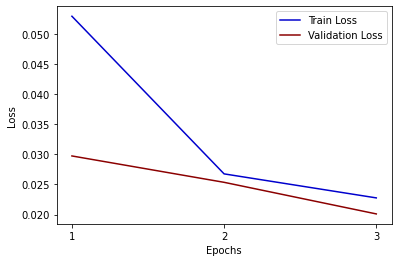

In [22]:
show_experiment_graph(history)